### Probablistic LSTM Modal

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

filename = "EURUSD_M1_2023.csv"


df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
data = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
data = data.dropna(axis=0)


data = data['close']


print(data.head(10))
print(data.describe())

# data = data.iloc[:100]


# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


data

0    1.06899
1    1.06788
2    1.06934
3    1.06929
4    1.06895
5    1.06939
6    1.06941
7    1.06986
8    1.06999
9    1.06973
Name: close, dtype: float64
count    21632.000000
mean         1.080698
std          0.016278
min          1.045190
25%          1.068310
50%          1.081495
75%          1.092560
max          1.127040
Name: close, dtype: float64


0        1.06899
1        1.06788
2        1.06934
3        1.06929
4        1.06895
          ...   
34747    1.10391
34748    1.10354
34749    1.10349
34750    1.10366
34751    1.10361
Name: close, Length: 21632, dtype: float64

In [6]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# data_tensor = data_tensor[:100]

KeyError: "None of [Index(['close'], dtype='object')] are in the [index]"

In [6]:
# # Define the Gaussian LSTM model
# class GaussianLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(GaussianLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc_mean = nn.Linear(hidden_size, output_size)  # Output mean
#         self.fc_variance = nn.Linear(hidden_size, output_size)  # Output variance

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         mean = self.fc_mean(out[:, -1, :])  # Mean of the Gaussian distribution
#         variance = torch.exp(self.fc_variance(out[:, -1, :]))  # Variance (apply exp to ensure positivity)
#         return mean, variance


In [7]:
class DeterministicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DeterministicLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)  # Output a single point prediction

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        output = self.fc(lstm_out[-1])  # Use only the last output of the sequence
        return output

In [8]:

# # Train the model
# def train_model(model, criterion, optimizer, data_sequences_tensor, target_labels, num_epochs=100):
#     losses = []
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         mean, variance = model(data_sequences_tensor)
#         loss = criterion(target_labels, mean, variance)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#         if (epoch+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     return losses

# # Define negative log likelihood loss for Gaussian distribution
# def gaussian_nll_loss(y_true, mean, variance):
#     return torch.mean(0.5 * torch.log(variance) + 0.5 * ((y_true - mean) ** 2) / variance)

# # Make predictions and calculate upper and lower bounds
# def predict(model, data_sequences_tensor):
#     mean, variance = model(data_sequences_tensor)
#     std_dev = torch.sqrt(variance)
#     upper_bound = mean + 2 * std_dev  # 95% confidence interval
#     lower_bound = mean - 2 * std_dev  # 95% confidence interval
#     return mean, upper_bound, lower_bound



# # Parameters
# input_size = 1
# hidden_size = 10
# num_layers = 2
# output_size = 1
# sequence_length = 15
# num_epochs = 10
# learning_rate = 0.001

# # Instantiate the model and move to GPU
# model = GaussianLSTM(input_size, hidden_size, num_layers, output_size)

# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Prepare data with sequence length
# data_sequences_tensor = torch.cat([data_tensor[:, i:i+sequence_length, :] for i in range(len(data) - sequence_length)], dim=0)

# # Convert data sequences to PyTorch tensors and move to GPU
# data_sequences_tensor = data_sequences_tensor.to(device)

# # Target labels (using next data point as label for simplicity)
# target_labels = data_tensor[:, sequence_length:, :][:, -1, :].to(device)

# # Train the model
# losses = train_model(model, gaussian_nll_loss, optimizer, data_sequences_tensor, target_labels, num_epochs)

In [9]:
# Define the window size
window_size = 500

# Generate X_train and y_train tensors
X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# Convert y_train to have an extra dimension for single output
y_train = y_train.unsqueeze(2)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Model parameters
input_size = 1  # Assuming univariate time series
hidden_size = 32
learning_rate = 0.001
num_epochs = 500

# Create model instance
model = DeterministicLSTM(input_size, hidden_size)

# Move the model to the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


X_train shape: torch.Size([21132, 500, 1])
y_train shape: torch.Size([21132, 1, 1])


OutOfMemoryError: CUDA out of memory. Tried to allocate 25.20 GiB. GPU 0 has a total capacity of 6.00 GiB of which 3.70 GiB is free. Of the allocated memory 1.30 GiB is allocated by PyTorch, and 3.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Batch training 



In [7]:
# Define the window size

# Assuming you have defined data_tensor, window_size, and target_tensor previously

# Define window size
window_size = 500

# Generate X_train and y_train tensors
X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# Convert y_train to have an extra dimension for single output
y_train = y_train.unsqueeze(2)

# Split data into training and validation sets
split_ratio = 0.8  # 80% for training, 20% for validation
split_index = int(len(X_train) * split_ratio)

X_train_data, X_val_data = X_train[:split_index], X_train[split_index:]
y_train_data, y_val_data = y_train[:split_index], y_train[split_index:]

# Define batch size
batch_size = 32  # You can adjust this value based on your memory constraints

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_data, y_train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Model parameters
input_size = 1  # Assuming univariate time series
hidden_size = 32
learning_rate = 0.001
num_epochs = 500

# Create model instance
model = DeterministicLSTM(input_size, hidden_size)

# Move the model to the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for batch_data, batch_target in train_loader:
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_data, batch_target in val_loader:
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            output = model(batch_data)
            val_loss += criterion(output, batch_target).item()
        val_losses.append(val_loss / len(val_loader))
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

NameError: name 'data_tensor' is not defined

In [ ]:
output.cpu().detach().numpy()

array([[1.0687249],
       [1.0687301],
       [1.0687338],
       [1.0687367],
       [1.0687307],
       [1.0687357],
       [1.0687307],
       [1.0687268],
       [1.0687237],
       [1.068721 ],
       [1.0687267],
       [1.0687313],
       [1.0687362],
       [1.0687401],
       [1.0687432],
       [1.0687438],
       [1.0687466],
       [1.068748 ],
       [1.0687488],
       [1.0687511],
       [1.0687531],
       [1.0687541],
       [1.0687569],
       [1.068761 ],
       [1.0687627],
       [1.0687611],
       [1.0687605],
       [1.0687594],
       [1.0687606],
       [1.068761 ],
       [1.0687612],
       [1.0687854],
       [1.0688024],
       [1.0688162],
       [1.0688334],
       [1.0688471],
       [1.0688579],
       [1.0688667],
       [1.068874 ],
       [1.0688791],
       [1.0688812],
       [1.0688839],
       [1.06889  ],
       [1.0688918],
       [1.0688947],
       [1.0688992],
       [1.0688995],
       [1.0689014],
       [1.0689014],
       [1.0689024]],

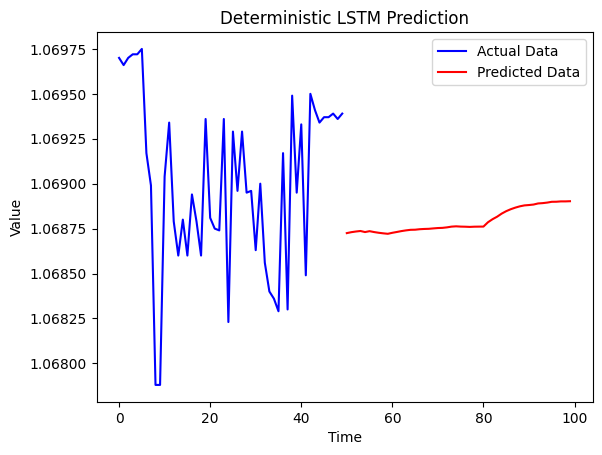

In [ ]:
# Plotting (optional)
plt.plot(data_tensor[0].cpu().numpy()[:len(data_tensor[0]) - window_size], label='Actual Data', color='blue')  # Convert tensor to numpy array

# Generate the range based on the length of the predicted data
predicted_range = range(window_size, window_size + len(output))
plt.plot(predicted_range, output.cpu().detach().numpy(), label='Predicted Data', color='red')

plt.title('Deterministic LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

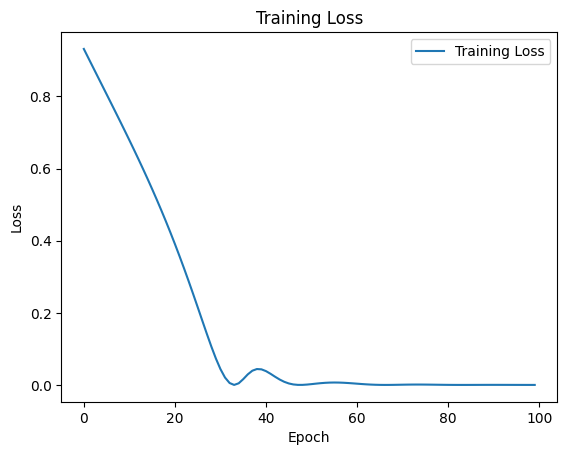

In [49]:
# Plot loss function within epochs
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
#### save trained modal
torch.save(model.state_dict(), './TrainedModals/D-LSTM_1M_1000epoch.pth')


In [ ]:
# Make predictions
# mean_pred, upper_bound_pred, lower_bound_pred = predict(model, data_sequences_tensor)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.98 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 10.78 GiB is allocated by PyTorch, and 970.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

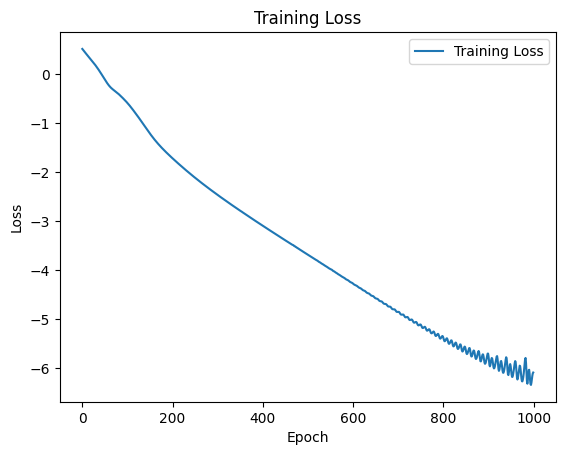

In [ ]:
# Plot loss function within epochs
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
data

,timestamp,open,high,low,close
0,2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06970
1,2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966
2,2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06970
3,2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972
4,2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972
...,...,...,...,...,...
322632,2023-12-29 16:54:00,1.10388,1.10390,1.10387,1.10387
322633,2023-12-29 16:55:00,1.10389,1.10395,1.10387,1.10387
322634,2023-12-29 16:56:00,1.10394,1.10394,1.10367,1.10367
322635,2023-12-29 16:57:00,1.10366,1.10366,1.10366,1.10366


In [48]:
# upper_bound_pred.squeeze().cpu().detach().numpy()

array([1.10829  , 1.10829  , 1.1082898, ..., 1.1082646, 1.1082647,
       1.1082647], dtype=float32)

In [49]:
# lower_bound_pred

tensor([[1.1014],
        [1.1014],
        [1.1014],
        ...,
        [1.1014],
        [1.1014],
        [1.1014]], device='cuda:0', grad_fn=<SubBackward0>)

In [50]:
# data.close

0         1.06970
1         1.06966
2         1.06970
3         1.06972
4         1.06972
           ...   
322632    1.10387
322633    1.10387
322634    1.10367
322635    1.10366
322636    1.10361
Name: close, Length: 322637, dtype: float64

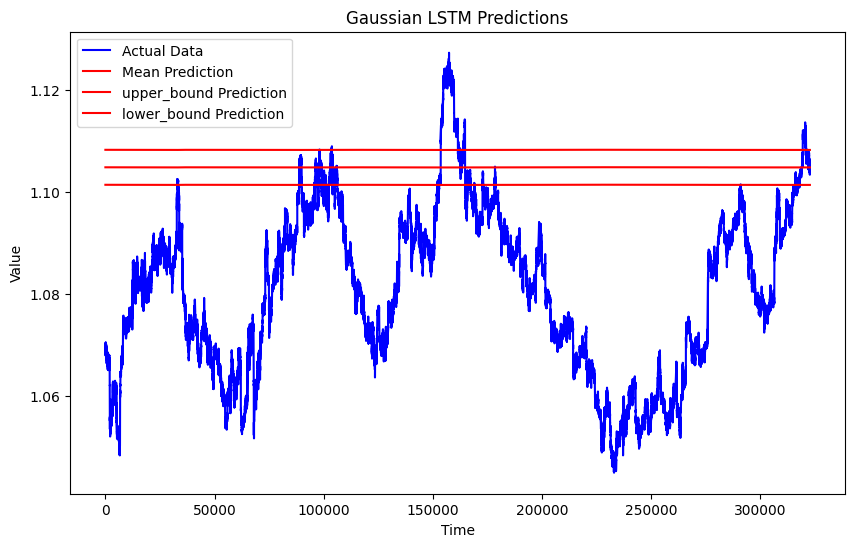

In [51]:
# Plot predictions
def plot_predictions(data, mean, upper_bound, lower_bound):
    # data = data.flatten()
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'], label='Actual Data', color='blue')
    plt.plot(mean, label='Mean Prediction', color='red')
    plt.plot(upper_bound, label='upper_bound Prediction', color='red')
    plt.plot(lower_bound, label='lower_bound Prediction', color='red')
    # plt.fill_between(range(len(mean)), upper_bound, lower_bound, color='orange', alpha=0.3, label='95% Confidence Interval')
    plt.title('Gaussian LSTM Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(data, mean_pred.squeeze().cpu().detach().numpy(), 
                  upper_bound_pred.squeeze().cpu().detach().numpy(), 
                  lower_bound_pred.squeeze().cpu().detach().numpy())

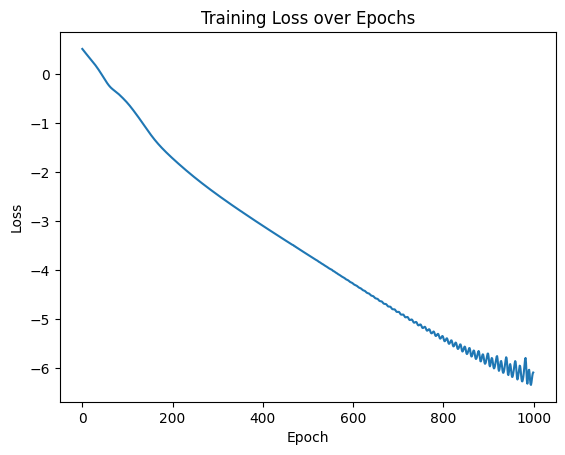

In [52]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Save PyTorch model
# torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')


In [53]:
# import matplotlib.pyplot as plt

# # Select a subset of 1000 timestamps
# subset_df = predictions_df.iloc[0:100]

# # Plot close price
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['Timestamp'], data['close'][0:100], label='Close Price', color='black')

# # Add dots to show predictions
# for index, row in subset_df.iterrows():
#     if row['Probability (Up)'] > 0.5:  # Upward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='green', label='Predicted Up', zorder=1)
#     else:  # Downward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='red', label='Predicted Down', zorder=1)

# plt.title('Close Price and Predicted Movements')
# plt.xlabel('Timestamp (Hourly)')
# plt.ylabel('Close Price')
# plt.xticks(subset_df['Timestamp'][::100], rotation=45, ha='right')  # Show every 10th timestamp for better readability
# plt.tight_layout()
# plt.show()


NameError: name 'predictions_df' is not defined